In [109]:
import pandas as pd

In [110]:
merged_66 = pd.read_csv('./1107_merge/66부분.csv',index_col=0)
merged_62 = pd.read_csv('./1107_merge/62부분.csv',index_col=0)
merged_62.index = pd.to_datetime(merged_62.index)
merged_66.index = pd.to_datetime(merged_66.index)

In [111]:
tool_62 = pd.read_csv('tool_62.csv')
tool_66 = pd.read_csv('tool_66.csv')
time_62 = pd.to_datetime(tool_62['enddatetime'])
time_66 = pd.to_datetime(tool_66['enddatetime'])

In [112]:
tool_62.tail(5)

,Unnamed: 0,primarykey,설비코드,정삭,툴코드,개수,inputdatetime,enddatetime,updatedatetime,mix,제품코드,규격
27,77,2205,CNC01,T03,CT202,36,2023-08-24 07:05:08.953,2023-08-24 07:05:08.953,2023-08-24 07:05:08.953,N,FSCN-0062,(APH031[36 EA])
28,78,2203,CNC01,T03,CT202,25,2023-08-24 05:47:20.057,2023-08-24 05:47:20.057,2023-08-24 05:47:20.057,N,FSCN-0062,(APH031[25 EA])
29,79,2201,CNC01,T03,CT202,50,2023-08-24 03:35:40.213,2023-08-24 03:35:40.213,2023-08-24 03:35:40.213,N,FSCN-0062,(APH031[50 EA])
30,80,2199,CNC01,T03,CT202,62,2023-08-24 00:50:21.187,2023-08-24 00:50:21.187,2023-08-24 00:50:21.187,N,FSCN-0062,(APH031[62 EA])
31,81,2197,CNC01,T03,CT202,83,2023-08-23 21:11:30.757,2023-08-23 21:11:30.757,2023-08-23 21:11:30.757,N,FSCN-0062,(APH031[83 EA])


In [113]:
def spliting(data: pd.DataFrame,tool:pd.Series,sec=60):
    split_last = [] # 마지막 몇 분
    split_first = [] # 최초 몇 분
    for i in range(len(tool)-1):
        start_time = tool.iloc[i].floor('S')
        split_first.append(data[start_time:start_time+pd.Timedelta(seconds=sec)])
        end_time = tool.iloc[i+1].floor('S')
        split_last.append(data[end_time-pd.Timedelta(seconds=sec):end_time])
    return split_first, split_last

In [167]:
# 초반 60초와 마지막 60초 분리하기 
start_62,last_62 = spliting(merged_62,time_62,sec=120)
start_66,last_66 = spliting(merged_66,time_66,sec=120)

개수별 분포 보기

In [168]:
num_62 = tool_62['개수'].iloc[:-1] # 마지막은 더이삭 알 수 없으니 삭제!!!!
num_66 = tool_66['개수'].iloc[:-1] # 마지막은 더이삭 알 수 없으니 삭제!!!!

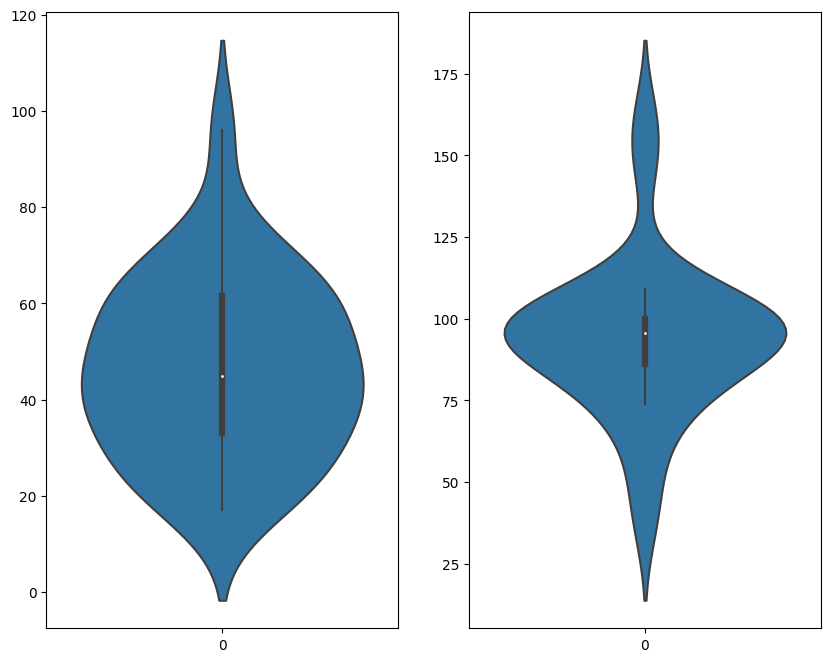

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1) 
sns.violinplot(num_62)
plt.subplot(1, 2, 2) 
sns.violinplot(num_66);

In [170]:
df1 = pd.DataFrame(num_62.describe()).transpose()
df2 = pd.DataFrame(num_66.describe()).transpose()
de = pd.concat([df1,df2])
de.index = ['62','66']
de

,count,mean,std,min,25%,50%,75%,max
62,31.0,46.322581,18.565895,17.0,33.00,45.0,61.5,96.0
66,28.0,93.678571,23.611130,38.0,86.25,95.5,100.0,161.0


### 1. 두 start 집단과 end 집단간의 차이점이 얼마나 있는가

#### 함수 코드

In [191]:
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np

def perform_t_tests(df1, df2):
    """
    두 데이터프레임의 모든 열에 대해 독립 표본 t-검정을 수행하는 함수입니다.

    Parameters:
    df1 (pandas.DataFrame): 첫 번째 데이터프레임
    df2 (pandas.DataFrame): 두 번째 데이터프레임

    Returns:
    results (pandas.DataFrame): 각 열에 대한 t-검정 결과를 포함하는 데이터프레임
    """
    # 결과를 저장할 빈 리스트를 초기화합니다.
    results = []

    # df1과 df2의 모든 열에 대해 반복합니다.
    for column in df1.columns:
        # 해당 열의 데이터를 추출합니다.
        data1 = df1[column].dropna()
        data2 = df2[column].dropna()

        # 데이터가 충분한 경우에만 t-검정을 수행합니다.
        if len(data1) > 1 and len(data2) > 1:
            # 독립 표본 t-검정을 수행합니다.
            t_statistic, p_value = ttest_ind(data1, data2)
            # 결과를 리스트에 추가합니다.
            p_value ="{:.4e}".format(p_value)
            results.append({'Column': column, 'P': p_value})
        else:
            # 데이터가 충분하지 않은 경우 결과를 리스트에 추가합니다.
            results.append({'Column': column, 'P':np.nan})

    # 결과 리스트를 데이터프레임으로 변환합니다.
    results_df = pd.DataFrame(results).transpose()
    results_df.columns = results_df.iloc[0,:]
    results_df.drop('Column',inplace=True)
    results
    return results_df

In [216]:
des_62 = pd.DataFrame()
for i in range(len(start_62)):
    df1 = perform_t_tests(start_62[i],last_62[i])
    df1.index=[i+1]
    des_62= pd.concat([des_62,df1])
des_62

Column,Active_Power_W1,Active_Power_W2,Active_Power_W3,Apparent_Power_Va1,Apparent_Power_Va2,Apparent_Power_Va3,Line_Current_L1,Line_Current_L2,Line_Current_L3,Line_Voltage_V12,Line_Voltage_V23,Line_Voltage_V31,x,y,z
1,5.2794e-19,8.0892e-18,1.2845e-20,2.9459e-22,1.9266e-20,1.0925e-20,1.4115e-22,4.6731e-20,5.1259e-21,1.3498e-29,4.8438e-22,7.4065e-28,1.6509e-01,2.4282e-09,9.7864e-01
2,2.1691e-25,1.3087e-23,7.5156e-25,1.5852e-23,1.3335e-21,3.6087e-23,3.7457e-23,3.7865e-22,2.4619e-23,4.8508e-15,1.7345e-15,1.9451e-11,2.3670e-01,3.6201e-03,9.9090e-01
3,6.6755e-01,2.3463e-01,7.9009e-01,9.0260e-01,2.3550e-02,2.0467e-01,6.6547e-01,1.9528e-02,1.2407e-01,3.6787e-104,3.4294e-111,1.5827e-144,1.3324e-16,2.7328e-45,9.8996e-01
4,7.7339e-10,6.1827e-09,2.7061e-10,3.6288e-07,4.6905e-06,9.0544e-08,4.1670e-07,4.2523e-06,1.3983e-07,2.7662e-06,2.2574e-07,2.8634e-18,1.3425e-04,2.2725e-10,1.9675e-01
5,1.6547e-01,7.9227e-01,3.0582e-01,4.2433e-03,2.0519e-01,1.7643e-01,8.6281e-03,3.1186e-01,2.6131e-01,3.7138e-88,1.4654e-83,4.7456e-83,6.5194e-01,2.2894e-02,9.8169e-01
6,3.3316e-37,7.0790e-25,3.4844e-36,4.8672e-43,4.1038e-28,8.6444e-35,1.9292e-40,4.2624e-25,1.2241e-32,8.5329e-210,3.8513e-212,NaN,5.6768e-10,3.3333e-25,9.9947e-01
7,1.3243e-16,7.7634e-19,4.9248e-24,6.1558e-18,3.2454e-16,2.1542e-23,1.1963e-21,1.7401e-19,1.8879e-25,1.6201e-124,1.9186e-109,NaN,7.5247e-06,4.1576e-23,8.4747e-01
8,3.0204e-01,2.7531e-01,6.4555e-01,6.7057e-02,8.4051e-01,9.1970e-01,8.9104e-02,9.4699e-01,8.6231e-01,5.9535e-08,8.5958e-01,2.9849e-25,2.6504e-05,2.5756e-21,9.7175e-01
9,1.6123e-06,3.5742e-03,6.6098e-03,1.0787e-03,1.0132e-03,1.4676e-02,4.9082e-05,3.0862e-05,2.3748e-03,1.2423e-214,1.5933e-222,1.0330e-208,5.4838e-03,1.4795e-10,9.8404e-01
10,7.8993e-09,2.8226e-14,4.2661e-20,3.1126e-12,2.8779e-12,6.6423e-18,2.1130e-12,1.5461e-11,1.5371e-17,1.6213e-65,3.7721e-43,6.3043e-35,1.0992e-02,2.8109e-01,2.8076e-01


In [211]:
des_66 = pd.DataFrame()
for i in range(len(start_66)):
    df1 = perform_t_tests(start_66[i],last_66[i])
    df1.index=[i+1]
    des_66= pd.concat([des_66,df1])
columns = des_66.columns
result = pd.concat([])

c:\Users\na062\anaconda3\envs\python11\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Column,Active_Power_W1,Active_Power_W2,Active_Power_W3,Apparent_Power_Va1,Apparent_Power_Va2,Apparent_Power_Va3,Line_Current_L1,Line_Current_L2,Line_Current_L3,Line_Voltage_V12,Line_Voltage_V23,Line_Voltage_V31,x,y,z
1,4.9716e-18,4.8101e-20,2.3200e-23,9.8554e-23,3.4265e-20,8.0768e-24,3.1295e-23,1.1118e-20,1.1564e-24,3.4849e-60,2.1368e-57,2.7240e-48,7.4804e-01,3.5569e-08,5.0939e-02
2,3.9533e-08,7.7134e-07,1.1403e-07,1.2638e-09,7.3613e-08,2.9162e-08,9.0530e-10,3.9509e-08,4.0679e-08,3.1156e-03,9.7044e-02,1.7355e-17,7.6334e-02,5.6344e-03,1.2412e-01
3,6.6500e-24,1.1207e-24,2.3564e-23,1.8648e-23,4.8550e-24,5.8038e-26,1.9501e-22,5.8518e-24,3.5210e-25,1.2651e-99,3.6655e-97,NaN,9.3497e-01,1.3083e-19,8.6839e-03
4,7.4953e-02,4.7917e-01,6.9661e-02,6.9559e-04,8.9337e-01,1.6623e-01,1.9465e-03,7.7118e-01,3.0836e-01,1.6568e-42,2.7680e-68,NaN,8.0159e-01,7.8916e-11,5.7220e-01
5,3.5417e-01,9.2087e-01,8.0477e-02,7.9548e-02,8.1652e-01,1.5490e-01,2.8557e-02,8.2934e-01,9.1507e-02,8.7475e-182,3.8083e-163,4.7245e-144,6.4904e-02,2.2896e-01,4.9706e-03
6,4.3998e-10,2.4006e-12,1.9519e-13,3.1485e-16,5.2145e-15,5.3815e-17,6.9097e-15,3.8611e-14,5.8198e-16,7.7105e-84,1.7476e-96,1.2277e-88,3.6520e-01,9.0870e-05,7.3165e-01
7,7.1353e-22,2.4883e-13,5.5187e-19,2.0833e-29,1.3751e-17,1.7440e-19,5.3837e-31,1.3764e-18,3.4151e-20,1.7168e-130,2.3116e-129,8.6349e-134,7.3906e-05,8.7641e-22,9.3850e-01
8,7.1830e-10,1.6631e-05,1.5374e-13,1.0258e-11,2.4811e-04,9.6848e-08,8.3544e-10,1.5786e-04,3.1472e-07,4.7113e-149,1.0415e-146,1.7746e-136,8.0061e-02,6.7700e-01,1.1953e-02
9,1.2057e-25,1.0251e-17,1.8646e-23,5.9899e-29,3.1055e-20,4.4708e-22,2.0161e-25,1.2615e-18,3.5268e-20,2.1387e-181,8.2860e-173,NaN,4.8819e-06,6.3390e-05,1.4203e-03
10,7.2653e-03,1.1403e-04,4.7901e-05,3.5747e-02,2.0534e-03,6.6425e-04,6.5392e-03,6.0536e-04,1.1912e-04,1.5747e-152,2.8213e-149,NaN,7.4677e-01,1.2047e-04,8.3032e-01
